# Solving 2048!

> This project aims to achieve a high score in the game of 2048.

Goals:
- Use selenium to open microsoft edge and control the webpage to play the game
- Access the game info real-time
- Run multiple processes in parallel to speed up data collection
- Train the model

In [1]:
#| default_exp core

In [2]:
#| hide
from nbdev.showdoc import *

In [45]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from fastcore.all import *
import numpy as np
import torch

In [269]:
url = "http://home.ustc.edu.cn/~hejiyan/flxg/"
driver = webdriver.Edge()
driver.get(url)

In [76]:
tile_container = driver.find_elements(By.CLASS_NAME, 'tile')
t = tile_container[0]

In [77]:
level = int(t.get_attribute('class').split()[1].split('-')[-1])
level

2

In [78]:
position = t.get_attribute('class').split()[2].split('-')[2:]
row, col = int(position[1])-1, int(position[0])-1

In [79]:
row, col

(2, 0)

In [80]:
grid = [[0 for i in range(4)] for j in range(4)]
grid

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

In [81]:
for each in tile_container:
    level = int(each.get_attribute('class').split()[1].split('-')[-1])
    position = each.get_attribute('class').split()[2].split('-')[2:]
    row, col = int(position[1])-1, int(position[0])-1
    level = np.log2(level)
    if grid[row][col] <= level:
        grid[row][col] = level

In [82]:
grid

[[0, 0, 0, 0],
 [0, 0, 0, 0],
 [np.float64(1.0), 0, 0, np.float64(1.0)],
 [0, 0, 0, 0]]

In [83]:
gameover = len(driver.find_elements(By.CLASS_NAME, 'game-over')) != 0

In [84]:
gameover

False

### Do the game play automation

In [96]:
from selenium.webdriver.common.keys import Keys
import random
import time

In [86]:
keys = [Keys.ARROW_DOWN, Keys.ARROW_LEFT, Keys.ARROW_UP, Keys.ARROW_RIGHT]

In [97]:
container = driver.find_element(By.TAG_NAME, 'body')

In [98]:
time.sleep(10)
while not len(driver.find_elements(By.CLASS_NAME, 'game-over')) != 0:
    container.send_keys(random.choice(keys))

In [94]:
score = int(driver.find_element(By.CLASS_NAME, 'score-container').text)
score

704

In [106]:
def gameplay(delay=10):
    url = "http://home.ustc.edu.cn/~hejiyan/flxg/"
    driver.get(url)
    container = driver.find_element(By.TAG_NAME, 'body')
    time.sleep(delay)
    while not len(driver.find_elements(By.CLASS_NAME, 'game-over')) != 0:
        container.send_keys(random.choice(keys))
    score = driver.find_element(By.CLASS_NAME, 'score-container').text
    if '\n' in score:
        score = score.split('\n')[0]
    score = int(score)
    print("分数：",score)

In [107]:
for i in range(10):
    gameplay(0)

分数： 568
分数： 728
分数： 1096
分数： 756
分数： 808
分数： 780
分数： 1056
分数： 1152
分数： 1008
分数： 2540


### Collect Gameplay Data

In [149]:
def init_grid():
    return [[0.0 for i in range(4)] for j in range(4)]
def update_tiles():
    grid = init_grid()
    tc = driver.find_elements(By.CLASS_NAME, 'tile')
    for each in tc:
        cls = each.get_attribute('class')
        level = int(cls.split()[1].split('-')[-1])
        position = cls.split()[2].split('-')[2:]
        row, col = int(position[1])-1, int(position[0])-1
        level = float(np.log2(level))
        if grid[row][col] <= level:
            grid[row][col] = level
    return grid.copy()
def is_game_over():
    return len(driver.find_elements(By.CLASS_NAME, 'game-over')) != 0
def get_score():
    score = driver.find_element(By.CLASS_NAME, 'score-container').text
    if '\n' in score:
        score = score.split('\n')[0]
    score = int(score)
    return score
def refresh(driver):
    driver.get(url)

In [230]:
def random_key():
    return random.choice(keys)
def send_random_key():
    key = random_key()
    container = driver.find_element(By.TAG_NAME, 'body')
    container.send_keys(key)
    return keys.index(key)
def send_key(index):
    container = driver.find_element(By.TAG_NAME, 'body')
    container.send_keys(keys[index])

In [160]:
refresh(driver)
states = []
actions = []
while not is_game_over():
    states.append(update_tiles())
    actions.append(send_random_key())
    time.sleep(0.02)
print(get_score())

1112


In [152]:
len(states)

151

In [162]:
actions[-10:]

[0, 2, 0, 2, 3, 1, 0, 2, 2, 1]

### Implementing a neural network

In [163]:
#| hide
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [264]:
model = nn.Sequential(
    nn.Linear(16, 128),
    nn.ReLU(),
    nn.Linear(128, 108),
    nn.ReLU(),
    nn.Linear(108, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 8),
    nn.ReLU(),
    nn.Linear(8, 4)
)

In [165]:
def flatten(lst):
     return torch.tensor(lst).view(1, 16)

In [170]:
F.softmax(model(flatten(states[-1])), dim=1)

tensor([[0.2226, 0.2244, 0.2841, 0.2688]], grad_fn=<SoftmaxBackward0>)

In [171]:
scores = []
all_states = []
all_actions = []
for i in range(10):
    refresh(driver)
    states = []
    actions = []
    while not is_game_over():
        states.append(update_tiles())
        actions.append(send_random_key())
        time.sleep(0.02)
    scores.append(get_score())
    all_states.append(states)
    all_actions.append(actions)

In [172]:
scores

[1424, 636, 488, 1868, 732, 1012, 1336, 1400, 1164, 696]

In [187]:
X = []
y = []
targ = np.percentile(scores, 50)

In [188]:
for i in range(10):
    if scores[i] > targ:
        X.extend(all_states[i])
        y.extend(all_actions[i])

In [197]:
X_train = torch.tensor(X).view(-1, 16)
X_train, X_train.shape

(tensor([[0., 0., 1.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 2.],
         ...,
         [1., 2., 3.,  ..., 7., 1., 2.],
         [1., 2., 1.,  ..., 7., 1., 2.],
         [2., 1., 2.,  ..., 7., 1., 2.]]),
 torch.Size([914, 16]))

In [202]:
y_train = torch.tensor(y).view(-1, 1)
y_train[:10], y_train.shape

(tensor([[3],
         [0],
         [2],
         [3],
         [2],
         [1],
         [1],
         [3],
         [2],
         [1]]),
 torch.Size([914, 1]))

In [270]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
def nll_loss(pred, goal):
    return torch.mean((pred-goal)**2)

In [216]:
loss = torch.mean(-torch.log(F.softmax(model(X_train), dim=1).gather(1, y_train)[:5]))
loss.backward()

In [209]:
model(X_train)

tensor([[-0.2140,  0.1534,  0.0546,  0.0998],
        [-0.2061,  0.1558,  0.0597,  0.1094],
        [-0.2398,  0.1856,  0.0360,  0.0989],
        ...,
        [-0.1910, -0.0025,  0.0620,  0.0805],
        [-0.2252,  0.0265,  0.0468,  0.0666],
        [-0.2122,  0.0110,  0.0648,  0.0661]], grad_fn=<AddmmBackward0>)

In [218]:
optimizer.step()

In [223]:
from torch.distributions import Categorical

In [228]:
probs = F.softmax(model(flatten(states[-1])), dim=1)
m = Categorical(probs)
m.sample()

tensor([2])

In [229]:
probs

tensor([[0.2062, 0.2503, 0.2737, 0.2699]], grad_fn=<SoftmaxBackward0>)

### Implement one complete training loop

In [243]:
goats = []
scores = []
all_states = []
all_actions = []
for i in range(10):
    refresh(driver)
    states = []
    actions = []
    data = []
    while not is_game_over():
        states.append(flatten(update_tiles()))
        probs = F.softmax(model(states[-1]), dim=1)
        m = Categorical(probs)
        action = m.sample()
        send_key(action)
        actions.append(action)
        data.append(states[-1], action)
        time.sleep(0.03)

    scores.append(get_score())
    if len(goats) < 5:
        goats.append((states, actions, scores[-1]))
    else:
        goats.sort(key=lambda x: x[-1])
        if goats[0][-1] < scores[-1]:
            goats[0] = (states, actions, scores[-1])
    all_states.append(states)
    all_actions.append(actions)

TypeError: key_func() missing 1 required positional argument: 'b'

In [237]:
torch.tensor(scores, dtype=float).mean()

tensor(802., dtype=torch.float64)

In [234]:
X = []
y = []
for i in range(10):
    if scores[i] > targ:
        X.extend(all_states[i])
        y.extend(all_actions[i])
X_train = torch.tensor(X).view(-1, 16)
y_train = torch.tensor(y).view(-1, 1)
for i in range(5):
    loss = torch.mean(-torch.log(F.softmax(model(X_train), dim=1).gather(1, y_train)[:5]))
    loss.backward()
    optimizer.step()

In [238]:
import time

In [266]:
goats = []

### Train for several hours with logging!

In [271]:
t0 = time.time()
for k in range(30):
    # 30 epochs, with 10 games per epoch
    print(f"\n{k}th epoch. ")
    t1 = time.time()
    scores = []
    all_states = []
    all_actions = []
    for j in range(10):
        refresh(driver)
        states = []
        actions = []
        while not is_game_over():
            states.append(update_tiles())
            probs = F.softmax(model(flatten(states[-1])), dim=1)
            m = Categorical(probs)
            action = m.sample()
            send_key(action)
            actions.append(action)
            time.sleep(0.03)
        scores.append(get_score())
        print(f"Completed {j}th game. Score: {scores[-1]}.")
        if len(goats) <= 10:
            goats.append((states, actions, scores[-1]))
        else:
            goats.sort(key=lambda x: x[-1])
            if goats[0][-1] < scores[-1]:
                goats[0] = (states, actions, scores[-1])
        all_states.append(states)
        all_actions.append(actions)
    print("Average score: ", torch.tensor(scores, dtype=float).mean())
    print("GOAT score that is going to be learnt: ", [i[-1] for i in goats])
    X = []
    y = []
    for i in range(10):
        X.extend(goats[i][0])
        y.extend(goats[i][1])
    X_train = torch.tensor(X).view(-1, 16)
    y_train = torch.tensor(y).view(-1, 1)
    for i in range(5):
        loss = torch.mean(-torch.log(F.softmax(model(X_train), dim=1).gather(1, y_train)[:5]))
        loss.backward()
        optimizer.step()
    t2 = time.time()
    print("Epoch complete. Time elapsed: ", t2-t1, "s. Total: ", t2-t0, "s.")


0th epoch. 
Completed 0th game. Score: 1428.
Completed 1th game. Score: 840.
Completed 2th game. Score: 1416.
Completed 3th game. Score: 1124.
Completed 4th game. Score: 900.
Completed 5th game. Score: 880.
Completed 6th game. Score: 1116.
Completed 7th game. Score: 956.
Completed 8th game. Score: 872.
Completed 9th game. Score: 560.
Average score:  tensor(1009.2000, dtype=torch.float64)
GOAT score that is going to be learnt:  [2368, 2372, 2380, 2380, 2384, 2392, 2416, 2428, 2824, 2952, 3068]
Epoch complete. Time elapsed:  88.53088998794556 s. Total:  88.53138303756714 s.

1th epoch. 


KeyboardInterrupt: 

In [288]:
model(flatten(states[176]))

tensor([[ 2.3761, -1.9841,  1.9022, -4.5854]], grad_fn=<AddmmBackward0>)

In [ ]:
refresh(driver)
states = []
actions = []
while not is_game_over():
    states.append(update_tiles())
    probs = F.softmax(model(flatten(states[-1])), dim=1)
    m = Categorical(probs)
    action = m.sample()
    send_key(action)
    actions.append(action)
    time.sleep(1)
print(get_score())

### Localize

In [352]:
a = np.array([[1],[ 2], [3]])
b = a.copy()

In [353]:
b[0][0]=3

In [355]:
a==b

array([[False],
       [ True],
       [ True]])

In [443]:
import numpy as np
import random
class Game2048:
    def __init__(self):
        self.size = 4
        self.score = 0
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.add_new_tile()
        self.add_new_tile()
        self.nomove = False
    def add_new_tile(self):
        empty_tiles = list(zip(*np.where(self.board == 0)))
        if empty_tiles:
            x, y = random.choice(empty_tiles)
            self.board[x][y] = 2 if random.random() < 0.9 else 4
    def move(self, direction):
        self.nomove = False
        prev_board = self.board.copy()
        if direction == 'down':
            self.board = np.rot90(self.board, -1)
            self._move_left()
            self.board = np.rot90(self.board)
        elif direction == 'up':
            self.board = np.rot90(self.board, 1)
            self._move_left()
            self.board = np.rot90(self.board, -1)
        elif direction == 'left':
            self._move_left()
        elif direction == 'right':
            self.board = np.fliplr(self.board)
            self._move_left()
            self.board = np.fliplr(self.board)
        self.nomove = np.abs(self.board - prev_board).sum()==0
        if self.nomove: return
        self.add_new_tile()
    def _move_left(self):
        self.reward = 0
        new_board = np.zeros((self.size, self.size), dtype=int)
        for i in range(self.size):
            row = self.board[i][self.board[i] != 0]
            new_row = []
            skip = False
            for j in range(len(row)):
                if skip:
                    skip = False
                    continue
                if j + 1 < len(row) and row[j] == row[j + 1]:
                    new_row.append(row[j] * 2)
                    self.score += row[j]*2
                    self.reward += row[j]*2
                    skip = True
                else:
                    new_row.append(row[j])
            new_board[i, :len(new_row)] = new_row
        self.board[:] = new_board
        return reward
    def is_game_over(self):
        if not np.any(self.board == 0):
            for i in range(self.size):
                for j in range(self.size - 1):
                    if self.board[i][j] == self.board[i][j + 1] or \
                        self.board[j][i] == self.board[j + 1][i]:
                        return False
            return True
        return False
game = Game2048()
print(game.board)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 2 2 0]]


In [333]:
game.move('down')
game.board

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 4, 4]])

In [342]:

game.board

array([[0, 0, 4, 2],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [344]:
model = nn.Sequential(
    nn.Linear(16, 128),
    nn.ReLU(),
    nn.Linear(128, 108),
    nn.ReLU(),
    nn.Linear(108, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 8),
    nn.ReLU(),
    nn.Linear(8, 4)
)

In [346]:
states[-1]

array([[0, 0, 0, 4],
       [0, 0, 0, 2],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [347]:
game.is_game_over()

False

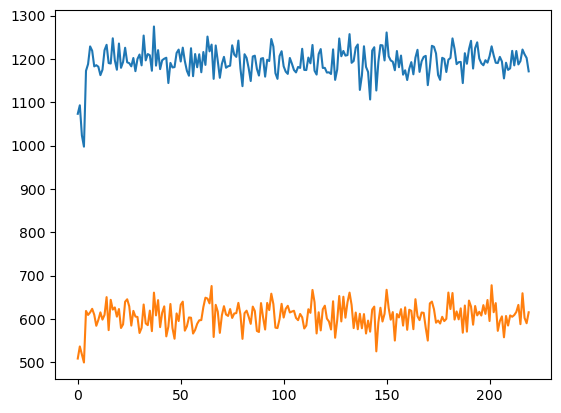

220th epoch. 


KeyboardInterrupt: 

In [405]:
plt.ion()
goats = []
model = nn.Sequential(
    nn.Linear(16, 128),
    nn.ReLU(),
    nn.Linear(128, 108),
    nn.ReLU(),
    nn.Linear(108, 84),
    nn.ReLU(),
    nn.Linear(84, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 8),
    nn.ReLU(),
    nn.Linear(8, 4)
)
optimizer = optim.Adam(model.parameters(), lr=0.01)
t0 = time.time()
epoch_num = []
epoch_score = []
epoch_var = []
for k in range(3000):
    # 30 epochs, with 10 games per epoch
    print(f"{k}th epoch. ")
    t1 = time.time()
    scores = []
    all_states = []
    all_actions = []
    for j in range(500):
        game = Game2048()
        states = []
        actions = []
        while not game.is_game_over():
            states.append(game.board.copy())
            probs = F.softmax(model(flatten(states[-1]).float()), dim=1)
            m = Categorical(probs)
            action = m.sample()
            action_str = ['down', 'left', 'up', 'right'][action]
            game.move(action_str)
            if game.nomove:
                action_str = random.choice(['down', 'left', 'up', 'right'])
                game.move(action_str)
            actions.append(action)
        scores.append(game.score)
        
        all_states.append(states)
        all_actions.append(actions)
        
    elite = np.percentile(scores, 80)
    avg = float(torch.tensor(scores, dtype=float).mean())
    var = float(torch.tensor(scores, dtype=float).std())
    print("Average score: ", avg)
    epoch_num.append(k)
    epoch_score.append(avg)
    epoch_var.append(var)
    clear_output(wait=True)
    plt.plot(epoch_num, epoch_score)
    plt.plot(epoch_num, epoch_var)
    plt.show()
    X = []
    y = []
    for i in range(100):
        if scores[i] > elite:
            X.extend(states)
            y.extend(actions)
    X_train = torch.tensor(X).view(-1, 16)
    y_train = torch.tensor(y).view(-1, 1)
    loss = torch.mean(-torch.log(F.softmax(model(X_train.float()), dim=1).gather(1, y_train)[:5]))
    loss.backward()
    optimizer.step()
    t2 = time.time()

In [376]:
np.percentile([2, 3, 5, 6, 7, 8], 70)

np.float64(6.5)

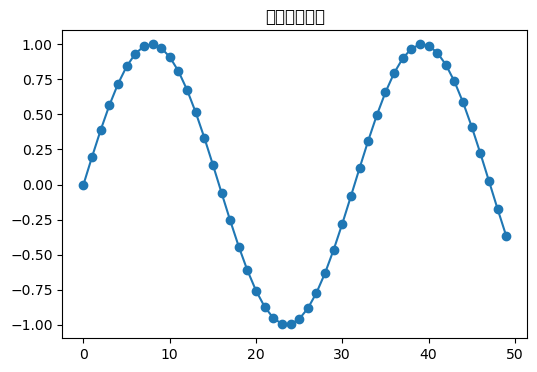

In [397]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

x, y = [], []
plt.ion()  # 打开交互模式

for i in range(50):
    print(i)
    x.append(i)
    y.append(np.sin(i/5))
    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker='o')
    plt.title("动态绘图示例")
    plt.show()


In [362]:
X_train

tensor([[ 0,  0,  2,  ...,  0,  0,  0],
        [ 4,  0,  0,  ...,  2,  0,  0],
        [ 0,  0,  0,  ...,  2,  0,  0],
        ...,
        [ 4,  2,  4,  ...,  8, 64,  2],
        [ 4,  2,  4,  ...,  8, 64,  2],
        [ 4,  2,  4,  ...,  8, 64,  2]])

### Policy Gradient

It seems that using the cross entropy method doesn't train well. 

I need to rewrite the data collection part.

In [259]:
model(flatten(states[1])) # 下左上右

tensor([[ 0.2096, -0.5115,  0.1361, -0.7855]], grad_fn=<AddmmBackward0>)

In [499]:

model = nn.Sequential(
    nn.Linear(16, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 8),
    nn.ReLU(),
    nn.Linear(8, 4)
)

In [505]:
game = Game2048()
experiences = []
while not game.is_game_over():
    game_prev = flatten(game.board.copy()).float().log1p()
    #import pdb;pdb.set_trace()
    probs = F.softmax(model(game_prev), dim=1)
    m = Categorical(probs)
    action = m.sample()
    action_str = ['down', 'left', 'up', 'right'][action]
    game.move(action_str)
    reward = game.reward
    game_after = flatten(game.board.copy()).float().log1p()
    experiences.append((game_prev, action, m.log_prob(action), reward, game_after))

In [420]:
real_rewards = []
cumu = 0
discount = 0.99
for i in experiences[::-1]:
    cumu += i[3]*discount
    real_rewards.insert(0, cumu)

In [424]:
experiences[0][2]

tensor([-1.3613], grad_fn=<SqueezeBackward1>)

In [425]:
losses = []
for i in range(len(experiences)):
    losses.append(-experiences[i][2]*real_rewards[i])

In [430]:
loss = torch.stack(losses).sum()
loss.backward()

Putting it all together:

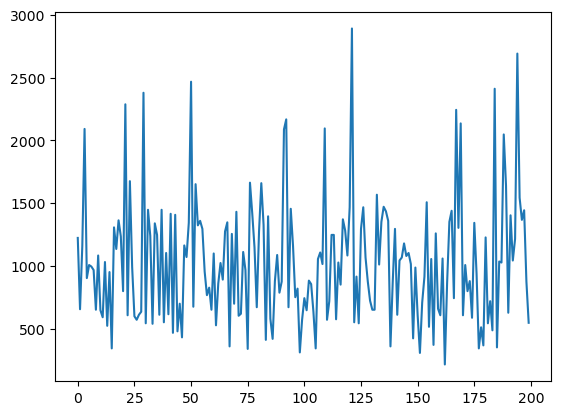

KeyboardInterrupt: 

In [507]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scores = []
max_repeat = 0
for l in range(2000):
    game = Game2048()
    experiences = []
    repeat = 0
    while not game.is_game_over():
        repeat += 1
        max_repeat = max([repeat, max_repeat])
        game_prev = flatten(game.board.copy()).float().log1p()
        probs = F.softmax(model(game_prev), dim=1)
        m = Categorical(probs)
        """
        if repeat >= 2:
            action = random.choice([0,1,2,3])
            prob = torch.log(torch.tensor([0.25]))
        else:    
        """
        action = m.sample()
        prob = m.log_prob(action)
        action_str = ['down', 'left', 'up', 'right'][action]
        game.move(action_str)
        #pdb.set_trace()
        reward = game.reward
        if game.nomove:
            reward = -1000
        game_after = flatten(game.board.copy()).float().log1p()
        experiences.append((game_prev, action, prob, reward, game_after))
    scores.append(game.score)
    real_rewards = []
    cumu = 0
    discount = 1.01
    for i in experiences[::-1]:
        cumu += i[3]*discount
        real_rewards.insert(0, cumu)
    real_rewards = [r * 0.01 for r in real_rewards]
    losses = []
    for i in range(len(experiences)):
        losses.append(-experiences[i][2]*real_rewards[i])
    loss = torch.stack(losses).sum()
    loss.backward()
    optimizer.step()
    clear_output(wait=True)
    if len(scores) > 200:
        scores = scores[-200:]
    plt.plot(scores)
    plt.show()

In [491]:
scores = 0
for i in range(50):
    game = Game2048()
    while not game.is_game_over():
        game_prev = flatten(game.board.copy()).float()
        probs = F.softmax(model(game_prev), dim=1)
        m = Categorical(probs)
        action = m.sample()
        action_str = ['down', 'left', 'up', 'right'][action]
        game.move(action_str)
        reward = game.reward
        game_after = game.board.copy()
    scores += game.score
print(scores/50)

KeyboardInterrupt: 

In [488]:
class CNN2048(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 4x4x1 -> 4x4x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 4x4x32 -> 4x4x64
        self.fc = nn.Linear(64*4*4, 4)  # Flatten to 4 actions
    
    def forward(self, x):
        x = x.view(-1, 1, 4, 4)  # Reshape to 4x4 grid
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

In [489]:
model = CNN2048()

### Deep Q Networks

In [579]:
class FullyConnectedQNetwork(nn.Module):
    def __init__(self, nin=80, nout=4):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nin, 192),
            nn.ReLU(),
            nn.Linear(192, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, nout)
        )
    def forward(self, x):
        return self.model(x)
def mse_loss(pred, goal):
    return torch.mean((pred-goal)**2)    

In [567]:
model = FullyConnectedQNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [587]:
def get_state(game):
    states = []
    for move in ['down', 'left', 'up', 'right']:
        new_game = Game2048()
        new_game.board = game.board.copy()
        new_game.move(move)
        states.append(flatten(new_game.board.copy()).float().log1p())  
    state = flatten(game.board.copy()).float().log1p()
    states = [state] + states
    new_state = torch.cat(states, dim=1)
    return new_state

In [588]:
total_reward = 0
done = False
game = Game2048()

gamma = 0.99
experience_pool = []
while not game.is_game_over():
    state = get_state(game)
    if np.random.rand() > 0.2:
        action = int(model(state).argmax())
    else:
        action = random.randint(0, 3)
    game.move(['down', 'left', 'up', 'right'][action])
    next_state = get_state(game)
    if game.nomove:
        reward = -100
    else:
        reward = game.reward
    with torch.no_grad():
        target = reward + gamma*model(next_state).max()*(not game.is_game_over())
    experience_pool.append((state, action, target))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x80 and 272x324)

In [598]:
random.shuffle(experience_pool)
batch_size = 32
for k in range(0, len(experience_pool), batch_size):
    states, actions, targets = zip(*experience_pool[k:k+batch_size])
    X = torch.stack(states)
    y = torch.stack(targets)
    q_values = model(X).squeeze()
    #pdb.set_trace()
    chosen_q_values = q_values.gather(1, torch.tensor(actions).unsqueeze(1))
    loss = mse_loss(chosen_q_values.squeeze(), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
def get_state(game):
    states = []
    for move in ['down', 'left', 'up', 'right']:
        new_game = Game2048()
        new_game.board = game.board.copy()
        new_game.move(move)
        states.append(flatten(new_game.board.copy()).float().log1p())  
    for move in ['down', 'left', 'up', 'right']:
        new_game = Game2048()
        new_game.board = game.board.copy()
        new_game.move(move)
        states.append(flatten(new_game.board.copy()).float().log1p())
    state = flatten(game.board.copy()).float().log1p()
    states = [state] + states
    new_state = torch.cat(states, dim=1)
    return new_state

In [599]:
class FullyConnectedQNetwork(nn.Module):
    def __init__(self, nin=144, nout=4):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nin, 192),
            nn.ReLU(),
            nn.Linear(192, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, nout)
        )
    def forward(self, x):
        return self.model(x)
def mse_loss(pred, goal):
    return torch.mean((pred-goal)**2)    

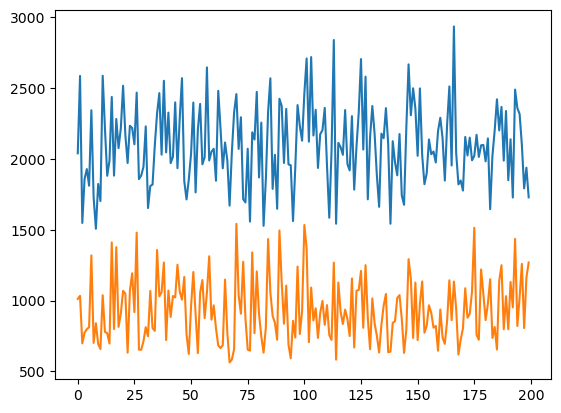

KeyboardInterrupt: 

In [611]:
episodes = 2000
epsilons = np.geomspace(0.5, 0.1, episodes)
# model = FullyConnectedQNetwork()
# optimizer = optim.Adam(model.parameters(), lr=0.002)
gamma = 0.995
games_each_round = 15
avgs = []
stds = []
for epoch in range(episodes):
    experience_pool = []
    rewards = []
    for game_round in range(games_each_round):
        game = Game2048()
        while not game.is_game_over():
            state = get_state(game)
            if np.random.rand() > 0.05:
                action = int(model(state).argmax())
            else:
                action = random.randint(0, 3)
            game.move(['down', 'left', 'up', 'right'][action])
            next_state = get_state(game)
            if game.nomove:
                reward = -20
            else:
                reward = game.reward
            with torch.no_grad():
                target = reward + gamma*model(next_state).max()*(not game.is_game_over())
            experience_pool.append((state, action, target))
        rewards.append(game.score)
    rt = torch.tensor(rewards).float()
    avgs.append(rt.mean())
    stds.append(rt.std())
    if len(avgs)>200:
        avgs.pop(0)
        stds.pop(0)
    clear_output(wait=True)
    plt.plot(avgs)
    plt.plot(stds)
    plt.show()
    random.shuffle(experience_pool)
    batch_size = 64
    for k in range(0, len(experience_pool), batch_size):
        states, actions, targets = zip(*experience_pool[k:k+batch_size])
        X = torch.stack(states)
        y = torch.stack(targets)
        q_values = model(X).squeeze(1)
        try:
            chosen_q_values = q_values.gather(1, torch.tensor(actions).unsqueeze(1))
        except Exception:
            pdb.set_trace()
        loss = mse_loss(chosen_q_values.squeeze(), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

In [562]:
torch.save(model.state_dict(), "400_epoch_80_nin.pth")

In [581]:
model_load = FullyConnectedQNetwork()

In [582]:
model_load.load_state_dict(torch.load("400_epoch_80_nin.pth", weights_only=True))

<All keys matched successfully>

In [590]:
game = Game2048()

In [604]:
model(get_state(Game2048()))

tensor([[-0.1269, -0.0465,  0.0922,  0.0480]], grad_fn=<AddmmBackward0>)

### Play on browser with newest model

In [608]:
url = "http://home.ustc.edu.cn/~hejiyan/flxg/"
driver = webdriver.Edge()
driver.get(url)
t0 = time.time()
t1 = time.time()
scores = []
all_states = []
all_actions = []
for j in range(10):
    refresh(driver)
    time.sleep(1)
    states = []
    actions = []
    while not is_game_over():
        game = Game2048()
        grid = np.array([[int(j) for j in i] for i in update_tiles()])
        #pdb.set_trace()
        game.board = grid
        state = get_state(game)
        states.append(state)
        action = model(state).argmax()
        send_key(action)
        actions.append(action)
        time.sleep(0.15)
    scores.append(get_score())
    print(f"Completed {j}th game. Score: {scores[-1]}.")
    all_states.append(states)
    all_actions.append(actions)
print("Average score: ", torch.tensor(scores, dtype=float).mean())
X = []
y = []
t2 = time.time()
print("Epoch complete. Time elapsed: ", t2-t1, "s. Total: ", t2-t0, "s.")

StaleElementReferenceException: Message: stale element reference: stale element not found in the current frame
  (Session info: MicrosoftEdge=140.0.3485.94); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#staleelementreferenceexception
Stacktrace:
0   msedgedriver                        0x00000001054ecfc0 msedgedriver + 5607360
1   msedgedriver                        0x00000001054e4b2c msedgedriver + 5573420
2   msedgedriver                        0x0000000104fdac20 msedgedriver + 289824
3   msedgedriver                        0x0000000104fe05ec msedgedriver + 312812
4   msedgedriver                        0x0000000104fe2df8 msedgedriver + 323064
5   msedgedriver                        0x0000000105061510 msedgedriver + 840976
6   msedgedriver                        0x00000001050608a0 msedgedriver + 837792
7   msedgedriver                        0x00000001050182d0 msedgedriver + 541392
8   msedgedriver                        0x00000001054ad8c8 msedgedriver + 5347528
9   msedgedriver                        0x00000001054b1408 msedgedriver + 5362696
10  msedgedriver                        0x000000010548db80 msedgedriver + 5217152
11  msedgedriver                        0x00000001054b1c90 msedgedriver + 5364880
12  msedgedriver                        0x000000010547f884 msedgedriver + 5159044
13  msedgedriver                        0x00000001054d26a0 msedgedriver + 5498528
14  msedgedriver                        0x00000001054d27c8 msedgedriver + 5498824
15  msedgedriver                        0x00000001054e4728 msedgedriver + 5572392
16  libsystem_pthread.dylib             0x00000001834efc0c _pthread_start + 136
17  libsystem_pthread.dylib             0x00000001834eab80 thread_start + 8


In [109]:
#| hide
import nbdev; nbdev.nbdev_export()

In [544]:
1+1

2